In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import math
import random
import pickle
import itertools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as plt

np.random.seed(42)

import pickle
from sklearn.preprocessing import OneHotEncoder

from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir(r"C:\Users\jaibi\Documents\GitHub\ECG_Capstone\MITBIH\arxiv-1805-00794\Data\input"))

# Any results you write to the current directory are saved as output.

['mitbih_test.csv', 'mitbih_train.csv']


In [7]:
df = pd.read_csv(r"C:\Users\jaibi\Documents\GitHub\ECG_Capstone\MITBIH\arxiv-1805-00794\Data\input\mitbih_train.csv", header=None)
df2 = pd.read_csv(r"C:\Users\jaibi\Documents\GitHub\ECG_Capstone\MITBIH\arxiv-1805-00794\Data\input\mitbih_test.csv", header=None)
df = pd.concat([df, df2], axis=0)

In [8]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


In [9]:
df[187].value_counts()

187
0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: count, dtype: int64

In [10]:
M = df.values
X = M[:, :-1]
y = M[:, -1].astype(int)

In [11]:
del df
del df2
del M

# Visual Input

In [12]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

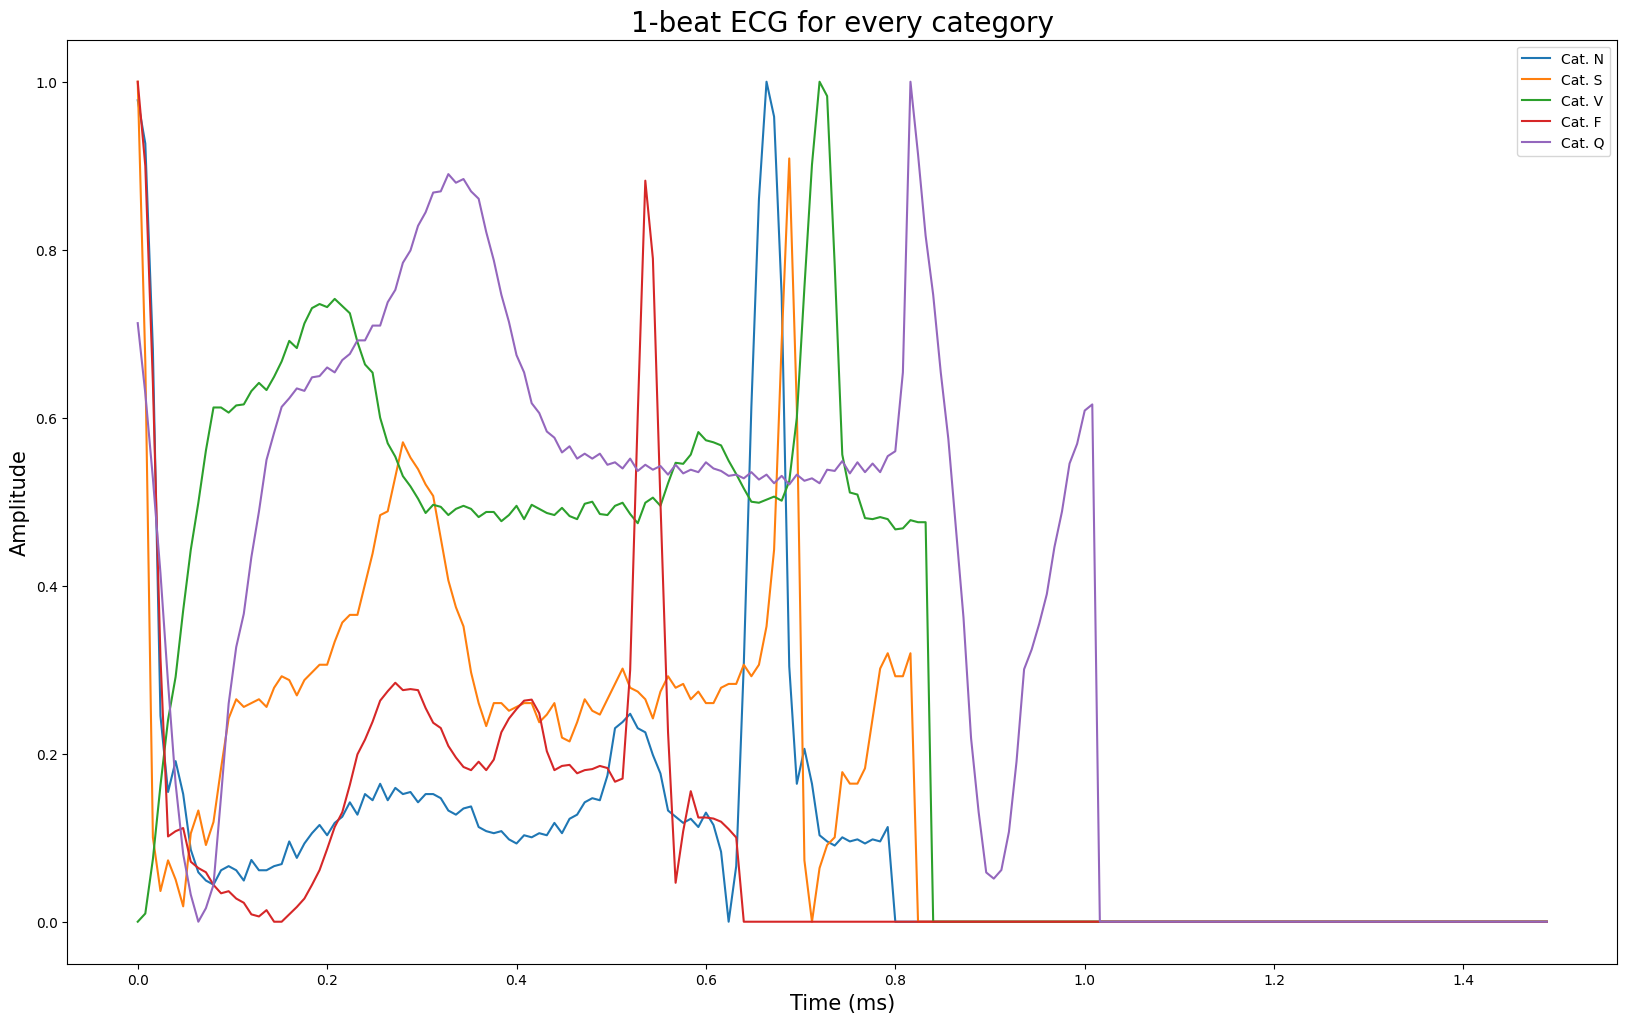

In [13]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][0], label="Cat. N")
plt.plot(x, X[C1, :][0], label="Cat. S")
plt.plot(x, X[C2, :][0], label="Cat. V")
plt.plot(x, X[C3, :][0], label="Cat. F")
plt.plot(x, X[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

# Data augmentation

To train properly the model, we sould have to augment all data to the same level. Nevertheless, for a first try, we will just augment the smallest class to the same level as class 1. With that we will be able to have a test set of around 5x800 observations.

In [14]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

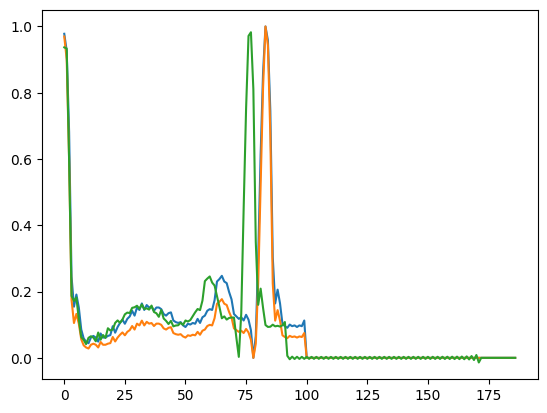

In [15]:
plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.plot(stretch(X[0, :]))
plt.show()

In [16]:
result = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 187)
classe = np.ones(shape=(result.shape[0],), dtype=int)*3
X = np.vstack([X, result])
y = np.hstack([y, classe])

# Split

In [17]:
subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

In [18]:
X_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])

X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

del X
del y

In [19]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [20]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109150, 187, 1)
y_train (109150,)
X_test (4000, 187, 1)
y_test (4000,)


In [21]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [22]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109150, 187, 1)
y_train (109150, 5)
X_test (4000, 187, 1)
y_test (4000, 5)


# Model

Now let's re-create the model from the ArXiv Document

In [23]:
n_obs, feature, depth = X_train.shape
batch_size = 500

In [24]:
K.clear_session()

inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 183, 32)   │        192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 183, 32)   │      5,152 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 183, 32)   │          0 │ conv1d_1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 183, 32)   │      5,152 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 183, 32)   │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 183, 32)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 90, 32)    │          0 │ activation_3[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 90, 32)    │      5,152 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 90, 32)    │          0 │ conv1d_5[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 90, 32)    │      5,152 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 90, 32)    │          0 │ conv1d_6[0][0],   │
│                     │                   │            │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 90, 32)    │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 43, 32)    │          0 │ activation_5[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 43, 32)    │      5,152 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 43, 32)    │          0 │ conv1d_7[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 43, 32)    │      5,152 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 43, 32)    │          0 │ conv1d_8[0][0],   │
│                     │                   │            │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 43, 32)    │          0 │ add_3[0][0]       │
│ (Activation)        │                   │            │                 

 Total params: 50,853 (198.64 KB)

 Trainable params: 50,853 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

In [27]:
adam = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [30]:
import numpy as np
import tensorflow as tf
from scipy.sparse import issparse

def ensure_3d_channels(*Xs):
    fixed = []
    for X in Xs:
        if X is None:
            fixed.append(None)
            continue
        X = np.asarray(X)
        if X.ndim == 2:         # (N, T) -> (N, T, 1)
            X = X[..., np.newaxis]
        elif X.ndim == 4 and X.shape[1] == 1:  # (N,1,T,1) -> (N,T,1)
            X = X[:, 0, :, :]
        X = np.squeeze(X)       # remove any leftover singleton dims except keep 3D
        if X.ndim == 2:
            X = X[..., np.newaxis]
        fixed.append(X.astype('float32'))
    return fixed

def densify_labels(y):
    # Handles SciPy sparse, tf.SparseTensor, dense one-hot, or integer labels
    if isinstance(y, tf.SparseTensor):
        y = tf.sparse.to_dense(y).numpy()
    elif issparse(y):
        y = y.toarray()
    else:
        y = np.asarray(y)

    # If already one-hot (2D and rows sum to ~1), cast to float32 dense
    if y.ndim == 2 and y.shape[1] > 1 and np.allclose(y.sum(axis=1), 1.0, atol=1e-6):
        return y.astype('float32'), 'onehot'

    # Otherwise assume class indices -> return int32 vector
    return y.astype('int32').reshape(-1), 'sparse'

# ---- normalize inputs ----
X_train, X_val, X_test = ensure_3d_channels(X_train, X_val if 'X_val' in locals() else None, X_test)

# ---- normalize labels ----
y_train, y_train_kind = densify_labels(y_train)
y_val,   y_val_kind   = densify_labels(y_val)   if 'y_val' in locals() else (None, None)
y_test,  y_test_kind  = densify_labels(y_test)

print("X_train:", X_train.shape, X_train.dtype)
print("X_val  :", None if X_val is None else (X_val.shape, X_val.dtype))
print("X_test :", X_test.shape, X_test.dtype)
print("y_train:", type(y_train), y_train.shape, y_train.dtype, y_train_kind)
print("y_val  :", None if y_val is None else (type(y_val), y_val.shape, y_val.dtype, y_val_kind))
print("y_test :", type(y_test), y_test.shape, y_test.dtype, y_test_kind)

# ---- choose the correct loss automatically ----
from tensorflow.keras.optimizers import Adam

adam = tf.keras.optimizers.Adam(learning_rate=1e-3)

if y_train_kind == 'onehot':
    loss = 'categorical_crossentropy'
    metrics = ['accuracy']
else:  # 'sparse' (integer ids)
    loss = 'sparse_categorical_crossentropy'
    metrics = ['accuracy']

model.compile(optimizer=adam, loss=loss, metrics=metrics)

X_train: (109150, 187, 1) float32
X_val  : None
X_test : (4000, 187, 1) float32
y_train: <class 'numpy.ndarray'> (109150, 5) float32 onehot
y_val  : None
y_test : <class 'numpy.ndarray'> (4000, 5) float32 onehot


In [31]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [34]:
history = model.fit(X_train, y_train, 
                    epochs=75, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lrate])

Epoch 1/75
219/219 - 4s - 17ms/step - accuracy: 0.9821 - loss: 0.0592 - val_accuracy: 0.8842 - val_loss: 0.4035 - learning_rate: 1.0000e-03
Epoch 2/75
219/219 - 4s - 16ms/step - accuracy: 0.9836 - loss: 0.0534 - val_accuracy: 0.9100 - val_loss: 0.3262 - learning_rate: 1.0000e-03
Epoch 3/75
219/219 - 4s - 16ms/step - accuracy: 0.9841 - loss: 0.0511 - val_accuracy: 0.9043 - val_loss: 0.3233 - learning_rate: 1.0000e-03
Epoch 4/75
219/219 - 4s - 17ms/step - accuracy: 0.9854 - loss: 0.0469 - val_accuracy: 0.8955 - val_loss: 0.3260 - learning_rate: 1.0000e-03
Epoch 5/75
219/219 - 4s - 19ms/step - accuracy: 0.9862 - loss: 0.0435 - val_accuracy: 0.9065 - val_loss: 0.2727 - learning_rate: 1.0000e-03
Epoch 6/75
219/219 - 4s - 17ms/step - accuracy: 0.9868 - loss: 0.0404 - val_accuracy: 0.9233 - val_loss: 0.2630 - learning_rate: 1.0000e-03
Epoch 7/75
219/219 - 4s - 17ms/step - accuracy: 0.9875 - loss: 0.0383 - val_accuracy: 0.9178 - val_loss: 0.2921 - learning_rate: 1.0000e-03
Epoch 8/75
219/219 -

In [35]:
y_pred = model.predict(X_test, batch_size=1000)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 


In [36]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       800
           1       0.99      0.84      0.91       800
           2       1.00      0.92      0.96       800
           3       0.97      0.95      0.96       800
           4       0.99      0.99      0.99       800

    accuracy                           0.94      4000
   macro avg       0.95      0.94      0.94      4000
weighted avg       0.95      0.94      0.94      4000



In [38]:
print("ranking-based average precision : {:.3f}".format(
    label_ranking_average_precision_score(y_test, y_pred)
))
print("Ranking loss : {:.3f}".format(
    label_ranking_loss(y_test, y_pred)
))
print("Coverage_error : {:.3f}".format(
    coverage_error(y_test, y_pred)
))


ranking-based average precision : 0.969
Ranking loss : 0.018
Coverage_error : 1.074


Confusion matrix, without normalization


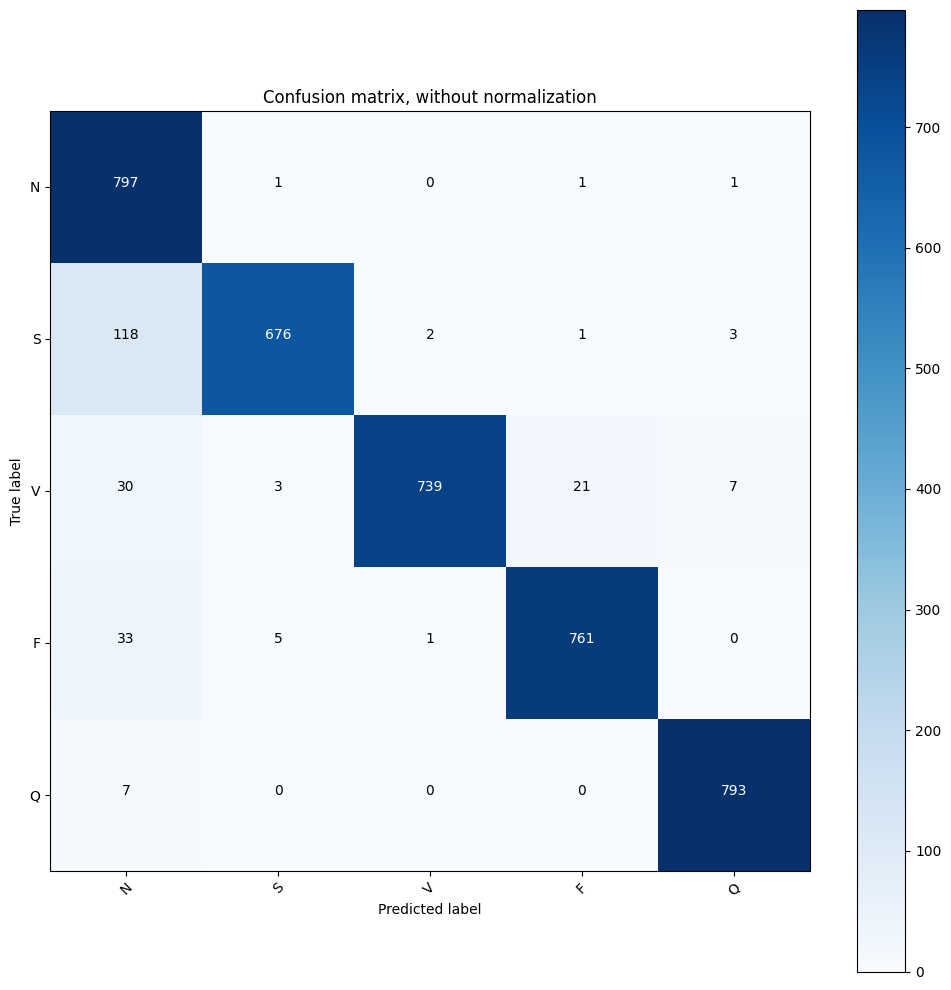

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')
plt.show()